- Inputs (either/or):
    - Binary vectors (Bernoulli)
    - bipolar vectors (Rademacher)
    - real values vectors (Gaussian)
- Objectives (either/or):
    - classify perfect match vs every other vector under varying SNR
    - maximize information gain
- Thresholds (either/or):
    - uniformly spaced
    - symmetric but non-uniformly spaced
    - arbitrarily spaced

In [3]:
%pip install -q jax jaxlib numpyro numpy matplotlib funsor seaborn xarray
import __init__
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp


import numpy as np

from matplotlib import pyplot as plt
plt.style.use('ggplot')
from matplotlib.patches import Rectangle

from adim import *


Note: you may need to restart the kernel to use updated packages.
Adding '/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing' to path...


/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.transforms import Bbox, TransformedBbox
from mpl_toolkits.axes_grid1.inset_locator import BboxConnectorPatch


def plot_panel(
    ax,
    vector_length,
    thresholds,
    noise_std,
    threshold_kwargs=dict(linestyle=":", linewidth=1, color="black"),
    inside_color="C0",
    outside_color="C1",
    inset_color=None,
    zoom_connector_kwargs=dict(loc1a=3, loc1b=4, loc2a=2, loc2b=1, ec="black"),
    titles = ["", "", ""],
    title_loc = "left",
    distribution="bipolar", 
    fixed=0,
    yscale=1,
    zoom = None
):
    fig = ax[0].get_figure()
    ax_density, ax_zoomed = ax

    tmin, tmax = float(thresholds[1]), float(thresholds[-2])
    

    # compute the "background" probability distribution
    nn = np.arange(vector_length + 1) * 2 - vector_length
    # pp = np.exp(dists.Binomial(vector_length, 0.5).log_prob(xx))
    p_n = jnp.exp(
        log_pdf_n(
            nn, vector_length=vector_length, distribution=distribution, fixed=fixed
        )
    )

    if zoom is not None:
        xmin, ymin, xmax, ymax = float(zoom[0]), float(zoom[1]), float(zoom[2]), float(zoom[3])
    else:
        xmin, xmax = tmin - 10, tmax + 10
        ymin, ymax = -p_n.max() * yscale * 0.05, p_n.max() * yscale * 1.05

    # create the density plot

    # compute area between thresholds
    total = p_n.sum(where=(tmin <= nn) * (nn <= tmax))
    rect = Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin, edgecolor="black", facecolor=inset_color
    )

    p_x = jnp.exp(
        log_pdf_x(
            nn, vector_length=vector_length, distribution=distribution, fixed=fixed
        )
    )

    ax_density.add_patch(rect)
    # ax.fill_between(nn, ymax, p_n, where=(nn >= xmin) * (nn <= xmax), color=threshold_color)
    ax_density.fill_between(
        nn,
        p_x * yscale,
        0,
        where=(nn >= tmin) * (nn <= tmax),
        color=inside_color,
        alpha=0.5,
        label=f"in range\n({100*total:.1f}%)",
    )
    ax_density.fill_between(
        nn,
        p_x * yscale,
        0,
        where=np.logical_not((nn >= tmin) * (nn <= tmax)),
        color=outside_color,
        alpha=0.5,
        label=f"clipped\n({100*(1-total):.1f}%)",
    )
    # ax.vlines([opt_thresholds[1],opt_thresholds[-2]], 0, ymax, color=threshold_color)
    ax_density.plot(nn, p_x * yscale, color="gray")

    # create the zoomed-in plot
    xx = np.linspace(xmin, xmax, 1001)

    p_x = jnp.exp(
        log_pdf_x(
            xx,
            noise_std=noise_std,
            vector_length=vector_length,
            distribution=distribution,
            fixed=fixed,
        )
    )
    p_n = jnp.exp(
        log_pdf_n(
            nn, vector_length=vector_length, distribution=distribution, fixed=fixed
        )
    )

    c = BboxConnectorPatch(
        TransformedBbox(rect.get_bbox(), ax_density.transData),
        ax_zoomed.bbox,
        **zoom_connector_kwargs,
        clip_on=False,
    )

    ax_zoomed.add_patch(c)
    c.set_in_layout(False)

    idx_in = (tmin <= xx) * (xx <= tmax)
    ax_zoomed.patch.set_color(inset_color)
    ax_zoomed.fill_between(xx, p_x * yscale, 0, where=idx_in, color=inside_color, alpha=0.5)
    ax_zoomed.fill_between(
        xx, p_x * yscale, 0, where=np.logical_not(idx_in), color=outside_color, alpha=0.5
    )
    # ax_zoomed.plot(xx, p_x, color="gray")

    # ax_density.legend(loc="lower center", bbox_to_anchor=(0.5, 0.95), fancybox=False, facecolor="none", edgecolor="none", ncol=4)

    ax_zoomed.set_xlabel("real input (zoomed)")

    if zoom is not None:
        ymin, ymax = float(zoom[1]), float(zoom[3])
    else:
        ymin, ymax = -p_x.max() * yscale * 0.05, p_x.max() * yscale * 1.05
        
    ax_zoomed.set_ylim(ymin, ymax)
    ax_zoomed.set_xlim(xmin, xmax)

    ax_density.set_yticks([])
    ax_zoomed.set_yticks([])

    ax_zoomed.set_frame_on(True)
    # ax_zoomed.patch.set_edgecolor("black")
    for spine in ax_zoomed.spines.values():
        # spine.set_edgecolor('black')
        plt.setp(spine, color="black")

    for t in thresholds:
        ax_zoomed.axvline(t, **threshold_kwargs)
    ax_density.set_title(titles[0], loc=title_loc)
    ax_zoomed.set_title(titles[1], loc=title_loc)

    return fig, ax_density

In [5]:
vector_length = 256
num_bits = jnp.array([4,5,6])
phase = jnp.linspace(-2, 2, 10)
scale = jnp.logspace(-1, 2, 100)

noise_std = jnp.logspace(-2, 1, 200)
fixed = jnp.array([0])

MIs = sweep(
    vector_length,
    num_bits,
    phase,
    scale,
    noise_std,
    distribution="bipolar",
    fixed=fixed,
)
MIs

100%|██████████| 3/3 [01:00<00:00, 20.03s/it]


<xarray.DataArray (num_bits: 3, fixed: 1, noise_std: 200, phase: 10, scale: 100)> Size: 5MB
Array([[[[[1.22706106, 1.22706106, 1.22706106, ..., 0.9434507 ,
           0.94344956, 0.94344941],
          [1.22706106, 1.22706106, 1.22706106, ..., 0.99821021,
           0.99820907, 0.99820892],
          [0.99820891, 0.99820891, 0.99820891, ..., 0.99821021,
           0.998209  , 0.99820892],
          ...,
          [0.99820891, 0.99820891, 0.99820891, ..., 0.99821021,
           0.998209  , 0.99820892],
          [1.22706106, 1.22706106, 1.22706106, ..., 0.99821021,
           0.99820907, 0.99820892],
          [1.22706106, 1.22706106, 1.22706106, ..., 0.9434507 ,
           0.94344956, 0.94344941]],

         [[1.22706106, 1.22706106, 1.22706106, ..., 0.9434507 ,
           0.94344956, 0.94344941],
          [1.22706106, 1.22706106, 1.22706106, ..., 0.99821021,
           0.99820907, 0.99820892],
          [0.99820891, 0.99820891, 0.99820891, ..., 0.99821021,
           0.998209  , 0.99820892],
...
          [0.5612584 , 0.56757506, 0.57427885, ..., 0.46764179,
           0.46761241, 0.46760596],
          [0.56052279, 0.56683668, 0.57353774, ..., 0.46696987,
           0.46693955, 0.46693285],
          [0.55954339, 0.56585358, 0.572551  , ..., 0.46607543,
           0.46604386, 0.46603683]],

         [[0.54148076, 0.54746164, 0.55380964, ..., 0.45290034,
           0.45286312, 0.45285456],
          [0.54240774, 0.54839191, 0.55474314, ..., 0.45375026,
           0.45371448, 0.4537063 ],
          [0.54310396, 0.54909059, 0.55544423, ..., 0.45438873,
           0.45435401, 0.45434612],
          ...,
          [0.54310396, 0.54909059, 0.55544423, ..., 0.45438873,
           0.45435401, 0.45434612],
          [0.54240774, 0.54839191, 0.55474314, ..., 0.45375026,
           0.45371448, 0.4537063 ],
          [0.54148076, 0.54746164, 0.55380964, ..., 0.45290034,
           0.45286312, 0.45285456]]]]], dtype=float64)
Coordinates:
  * num_bits   (num_bits) int64 24B 4 5 6
  * fixed      (fixed) int64 8B 0
  * noise_std  (noise_std) float64 2kB 0.01 0.01035 0.01072 ... 9.329 9.659 10.0
  * phase      (phase) float64 80B -2.0 -1.556 -1.111 ... 1.111 1.556 2.0
  * scale      (scale) float64 800B 0.1 0.1072 0.115 ... 86.97 93.26 100.0

In [6]:
# find the maximum MI for each noise level
max_idx = MIs.argmax(dim=("phase", "scale"))
max_phase = MIs.coords["phase"][max_idx["phase"]]
max_scale = MIs.coords["scale"][max_idx["scale"]]
max_MI = MIs.max(dim=("phase", "scale"))


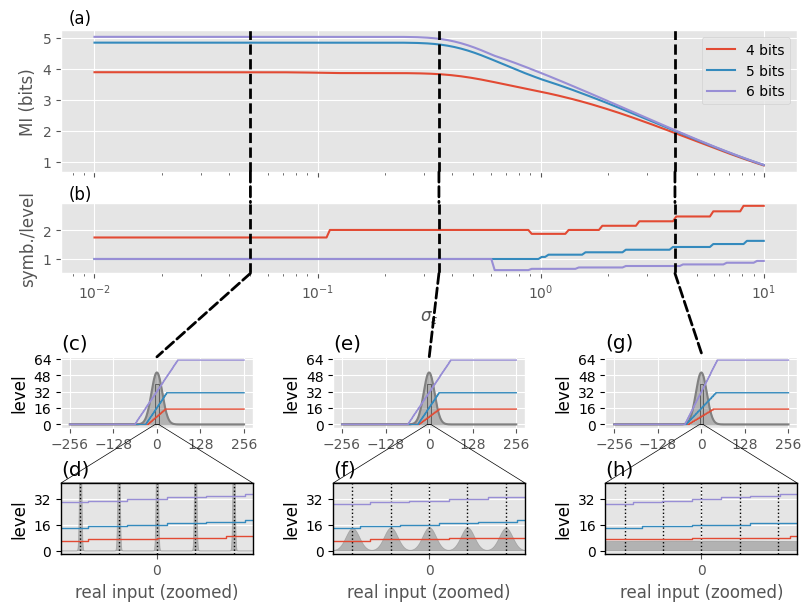

In [12]:
from matplotlib import transforms
from matplotlib.patches import ConnectionPatch


fig, ax = plt.subplot_mosaic(
    [
        ["MI", "MI", "MI"],
        ["scale", "scale", "scale"],
        ["dist 1", "dist 2", "dist 3"],
        ["zoom 1", "zoom 2", "zoom 3"],
    ],
    figsize=(8, 6),
    height_ratios=[2,1,1,1],
    constrained_layout=True,
)

lines = []
# lines += ax["MI"].semilogx(
#     noise_std, enob(.T), linestyle="--", color="black", label="ENOB"
# )
lines += ax["MI"].semilogx(
    noise_std, max_MI.squeeze().T, label=[f"{int(n)} bits" for n in num_bits]
)


ax["scale"].semilogx(noise_std, max_scale.squeeze().T/2)
plt.setp(ax["MI"].get_xticklabels(), visible=False)
ax["scale"].sharex(ax["MI"])

ax["MI"].legend(handles=lines, loc="upper right")


line_connector_kwargs=dict(linewidth=2, linestyle="--", color="black")

ax["MI"].set_ylabel("MI (bits)")
ax["scale"].set_ylabel("symb./level")
ax["scale"].yaxis.set_major_locator(MaxNLocator(integer=True))

# ax["MI"].set_title("Mutual Information vs noise for different bitwidths")
# ax["scale"].set_title("Optimal Scale")
ax["scale"].set_xlabel("$\\sigma_\\varepsilon$")

ax["MI"].annotate("(a)", (0.01, 1.05), xycoords="axes fraction", fontsize=12)
ax["scale"].annotate("(b)", (0.01, 1.05), xycoords="axes fraction", fontsize=12)

for i, (sig, ax_dist, ax_zoom) in enumerate([(0.05, ax["dist 1"], ax["zoom 1"]), (0.35, ax["dist 2"], ax["zoom 2"]), (4.0, ax["dist 3"], ax["zoom 3"])]):
    ax["MI"].axvline(sig, **line_connector_kwargs)
    ax["scale"].axvline(sig, **line_connector_kwargs)

    # plot line from scale axis to diat 1 axis
    con = ConnectionPatch(
        xyA=(sig, 0.0),
        xyB=(sig, 1.0),
        coordsA=transforms.blended_transform_factory(
            ax["MI"].transData, ax["MI"].transAxes
        ),
        coordsB=transforms.blended_transform_factory(
            ax["scale"].transData, ax["scale"].transAxes
        ),
        axesA=ax["MI"],
        axesB=ax["scale"],
        **line_connector_kwargs
    )
    fig.add_artist(con)
    con.set_in_layout(False)

    # plot line from scale axis to diat 1 axis
    con = ConnectionPatch(
        xyA=(sig, 0.0),
        xyB=(sig, 1.0),
        coordsA=transforms.blended_transform_factory(
            ax["scale"].transData, ax["scale"].transAxes
        ),
        coordsB=transforms.blended_transform_factory(
            ax_dist.transData, ax_dist.transAxes
        ),
        axesA=ax["scale"],
        axesB=ax_dist,
        **line_connector_kwargs
    )
    fig.add_artist(con)
    con.set_in_layout(False)

    plot_panel(
        [ax_dist, ax_zoom],
        vector_length,
        compute_even_levels(2**8, 2.0, 0.0).squeeze(),
        sig,
        zoom=(-5, 0, 5, 40),
        inset_color=(0.8, 0.8, 0.8, 0.5),
        titles=[["(c)", "(d)"],["(e)", "(f)"], ["(g)", "(h)"]][i],
        yscale = 256,
        inside_color="gray",
        outside_color="darkgray",
    )

    # get index corrsponding to sig
    idx = int(jnp.searchsorted(noise_std, sig))
    for j,b in enumerate(num_bits):
        plot_quantization(ax_dist, vector_length, b, float(max_scale[dict(num_bits=j, noise_std=idx)]), float(max_phase[dict(num_bits=j, noise_std=idx)]), plot_cdf=False, linecolor=f"C{j}", xticklocator=MultipleLocator(128), yticklocator=MultipleLocator(16))
        plot_quantization(ax_zoom, vector_length, b, float(max_scale[dict(num_bits=j, noise_std=idx)]), float(max_phase[dict(num_bits=j, noise_std=idx)]), plot_cdf=False, linecolor=f"C{j}", xticklocator=MultipleLocator(128), yticklocator=MultipleLocator(16))
    ax_zoom.set_ylim(-40*0.05, 40*1.05)

# fig.tight_layout()

In [13]:
fig.savefig("../figures/noise.pdf", bbox_inches="tight")
fig.savefig("../figures/noise.svg", bbox_inches="tight")
fig.savefig("../figures/noise.png", bbox_inches="tight", dpi=300)